In [1]:
import torch
from torch import nn
from geomloss import SamplesLoss
import matplotlib.pyplot as plt

In [2]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc = nn.Sequential(
            nn.Linear(1, 10),
            nn.ReLU(),
            nn.Linear(10, 30),
            nn.ReLU(),
            nn.Linear(30, 30),
            nn.ReLU(),
            nn.Linear(30, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )

        
    def forward(self, x):
        return self.fc(x)
    
    
def KL_loss_func(mu, log_var):
    kl_loss = torch.exp(log_var) + mu**2 - 1. - log_var
    
    return kl_loss * 0.5


class Loss(nn.Module):
    def __init__(self):
        super().__init__()
        self.loss_fn = KL_loss_func
        
    def forward(self, x):
        # get empirical mean
        mu_hat = x.mean(0)
        # get empirical log variance
        var_hat = torch.var(x, dim=0)
        log_var = torch.log(var_hat)
        
        return self.loss_fn(mu_hat, log_var)

### Naive approach with (1st and 2nd order) moment matching via KL divergence
(Transform uniform into normal distribution)

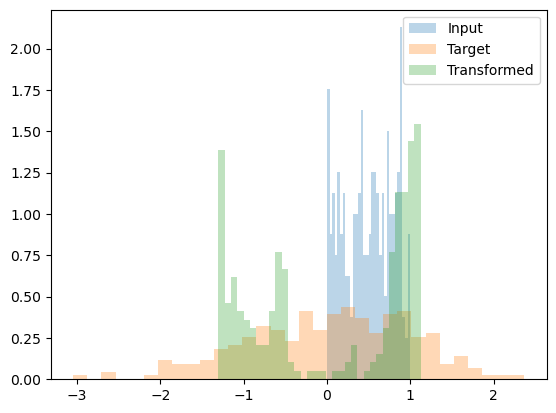

In [16]:
model     = Network()
opt       = torch.optim.Adam(model.parameters(), lr=0.1)
criterion = Loss()
# plot uniformly distributed data
x_show = torch.rand((256, 1))
plt.hist(x_show.numpy(), bins=32, alpha=0.3, label='Input', density=True)
#plt.show()
target = torch.randn((256, 1))
plt.hist(target.numpy(), bins=32, alpha=0.3, label='Target', density=True)

for _ in range(100):
    # get uniformly distributed data
    x_in  = torch.rand((32, 1))
    # transform into normal distributed data
    x_out = model(x_in)
    # calculate KL divergence
    loss = criterion(x_out)
    # pytorch things
    opt.zero_grad()
    loss.backward()
    opt.step()
    
plt.hist(model(x_show).detach().numpy(), bins=32, alpha=0.3, label='Transformed', density=True)
plt.legend()
plt.show()

### Better: Use OT loss

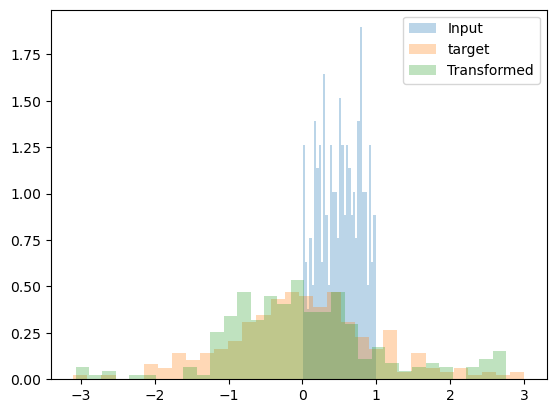

In [21]:
model     = Network()
opt       = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = SamplesLoss()

#x_in = torch.rand((32*32, 1)) - 0.5
x_in = torch.rand((256, 1)) 
plt.hist(x_in.numpy(), bins=32, alpha=0.3, density=True, label='Input')
# plt.show()

target = torch.randn((256, 1))# * 10 - 5
plt.hist(target.numpy(), bins=32, alpha=0.3, density=True, label='Target')
# plt.show()

for _ in range(1000):
    # transform into normal distributed data
    x_out = model(x_in)
    # calculate earth mover loss
    loss = criterion(x_out, target)
    # pytorch things
    opt.zero_grad()
    loss.backward()
    opt.step()
    
plt.hist(model(x_in).detach().numpy(), bins=32, alpha=0.3, density=True, label='Transformed')
plt.legend()
plt.show()